In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

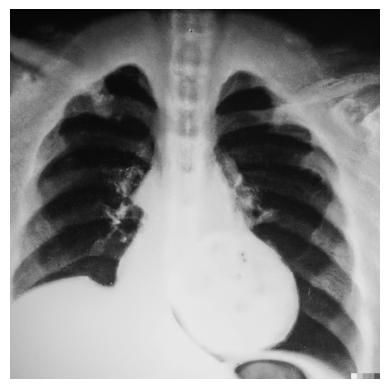

Gizlenmiş mesaj: merhaba
Çıkarılan mesaj: merhaba


In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def calculate_complexity(block):
    """8x8 blok için basit geçiş sayısına dayalı karmaşıklık hesaplar"""
    transitions = 0
    for row in block:
        transitions += np.sum(row[:-1] != row[1:])
    for col in block.T:
        transitions += np.sum(col[:-1] != col[1:])
    return transitions / 112  # 8 satır ve 8 sütun: 7 geçiş * 16

def embed_bpcs(image, message, threshold=0.3):
    img = image.convert('L')
    arr = np.array(img)
    binary_message = ''.join(format(ord(c), '08b') for c in message)
    bitplanes = [(arr >> i) & 1 for i in range(8)]

    msg_index = 0
    for plane_idx in range(7, -1, -1):
        plane = bitplanes[plane_idx]
        h, w = plane.shape
        for i in range(0, h, 8):
            for j in range(0, w, 8):
                if msg_index >= len(binary_message):
                    break
                block = plane[i:i+8, j:j+8]
                if block.shape != (8, 8):
                    continue
                if calculate_complexity(block) > threshold:
                    char_bits = np.array(list(binary_message[msg_index:msg_index+64]), dtype=np.uint8)
                    if char_bits.size < 64:
                        char_bits = np.pad(char_bits, (0, 64 - char_bits.size), 'constant')
                    plane[i:i+8, j:j+8] = char_bits.reshape((8, 8))
                    msg_index += 64
        bitplanes[plane_idx] = plane

    result = sum((bitplanes[i] << i) for i in range(8))
    stego_image = Image.fromarray(np.uint8(result))
    return stego_image

def extract_bpcs(image, threshold=0.3, length=1):
    img = image.convert('L')
    arr = np.array(img)
    bitplanes = [(arr >> i) & 1 for i in range(8)]

    extracted_bits = ''
    for plane_idx in range(7, -1, -1):
        plane = bitplanes[plane_idx]
        h, w = plane.shape
        for i in range(0, h, 8):
            for j in range(0, w, 8):
                block = plane[i:i+8, j:j+8]
                if block.shape != (8, 8):
                    continue
                if calculate_complexity(block) > threshold:
                    extracted_bits += ''.join(map(str, block.flatten()))
                    if len(extracted_bits) >= length * 8:
                        return ''.join(chr(int(extracted_bits[i:i+8], 2)) for i in range(0, length*8, 8))
    return ""

# 🔘 Kullanım
image_path = "/kaggle/input/awesomelungs/CT/DALLE 2022-09-28 20.04.59 - lungs CT image.png"
image = Image.open(image_path)
message = "merhaba"

# Mesajı göm
stego_image = embed_bpcs(image, message)

# Göster
plt.imshow(stego_image, cmap='gray')
plt.axis('off')
plt.show()

# Mesajı çıkar
extracted = extract_bpcs(stego_image, length=len(message))
print("Gizlenmiş mesaj:", message)
print("Çıkarılan mesaj:", extracted)
